Quick first look at the Chandra spectra, check for variation and phase coverage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
import lightkurve as lk

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
sp = glob.glob('test_spectra/*fits')
sp

['test_spectra/ob1_test_p1.fits', 'test_spectra/ob2_test_p1.fits']

In [3]:
fits.getdata(sp[0],1).names

['CHANNEL',
 'COUNTS',
 'STAT_ERR',
 'BACKGROUND_UP',
 'BACKGROUND_DOWN',
 'BIN_LO',
 'BIN_HI']

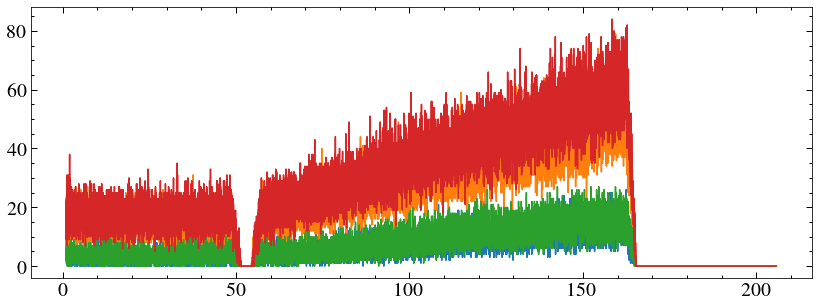

In [4]:
for s in sp:
    data = fits.getdata(s,1)
    plt.plot(data['BIN_LO'],data['COUNTS'])
    plt.plot(data['BIN_LO'],data['BACKGROUND_UP'])
    

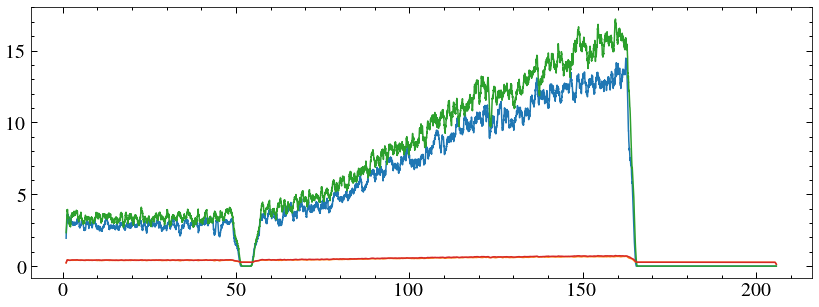

In [5]:
smooth = 50
for s in sp:
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    plt.plot(w, c1)
    plt.plot(w, ce1)
    

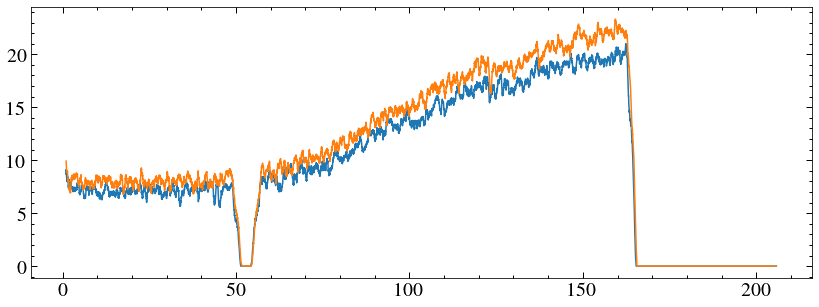

In [6]:
for s in sp:
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    plt.plot(w, c1/ce1)

In [7]:
int_counts = []
for s in sp:
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'][::-1], data['COUNTS'], data['STAT_ERR']
    mask = (w > 70) & ( w < 160)
    int_counts.append(np.trapz(c[mask], w[mask]))
print(int_counts)
print(int_counts[0]/int_counts[1])

[579.8937500000204, 677.775000000024]
0.8555844491165946


Timings?

In [8]:
hdul = fits.open(sp[0])
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'PRIMARY '                                                            
ORIGIN  = 'ASC     '           / Source of FITS file                            
CREATOR = 'cxc - Version CIAO 4.12' / tool that created this output             
DS_IDENT= 'ADS/Sa.CXO#obs/21181' / Dataset Identifier: DOI                      
CHECKSUM= 'lojknmgilmgilmgi'   / HDU checksum updated 2020-04-02T22:09:18       
DATASUM = '        '           / data unit checksum updated 2020-03-26T08:56:24 
DATE    = '2020-04-02T22:09:

0.6007639253439265
[0.02570951 0.54957062]
0.7171263456039014
[0.53431853 0.1596467 ]


(0.001, 0.999)

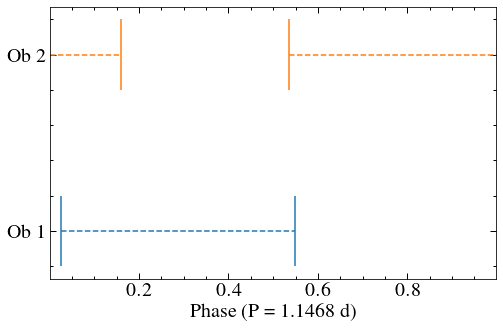

In [9]:
cols= ['C0', 'C1']
plt.figure(figsize=(8,5))
for i ,s in enumerate(sp):
    hdr = fits.getheader(s, 0)
    t = np.array([hdr['TSTART']/86400, hdr['TSTOP']/86400])
    t += hdr['MJDREF']
    print(t[1]-t[0])
    #if i == 0:
     #   tmin = t[0]
    #t = t - tmin
    #plt.errorbar(t, [i,i],  yerr=0.1)
    #plt.show()
    period = 1.1468 #d
    tep = (2458737.560-2400000.5)
    t -=tep  
    tfold = (t/ period) % 1
    #tfold = tfold[np.argsort(tfold)]
    print(tfold)
    #if i == 1:
     #   tfold = tfold-4
    plt.errorbar(tfold, [0.5*i,0.5*i],  yerr=0.1, ls='none', c=cols[i])
    if i == 0:
        plt.plot(tfold, [0.5*i,0.5*i], ls='--', c=cols[i])
    else:
        plt.plot([0, min(tfold)], [0.5*i,0.5*i], ls='--', c=cols[i])
        plt.plot([max(tfold), 1], [0.5*i,0.5*i], ls='--', c=cols[i])
plt.yticks([0, 0.5],['Ob 1', 'Ob 2'])
plt.xlabel('Phase (P = {} d)'.format(period))
plt.xlim(0.001, 0.999)
#plt.savefig('plots/phase_coverage.pdf')

Yes! Good work Chandra team!

In [10]:
(51906.00314998627+61959.71625995636)/(86400*1.146)

1.1499915104261869

Compare new spectra with the old EUVE spectrum

In [11]:
wv,fv,ev=np.loadtxt('../../spectra/euve/GD394_euve_added.dat', unpack=True) #load data

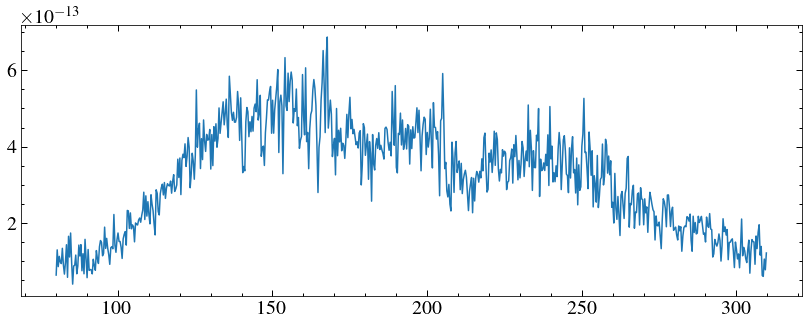

In [12]:
mask=(wv>80.)&(wv<310.) #mask out bad areas
wv,fv,ev=wv[mask], fv[mask], ev[mask] 
plt.plot(wv, fv)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


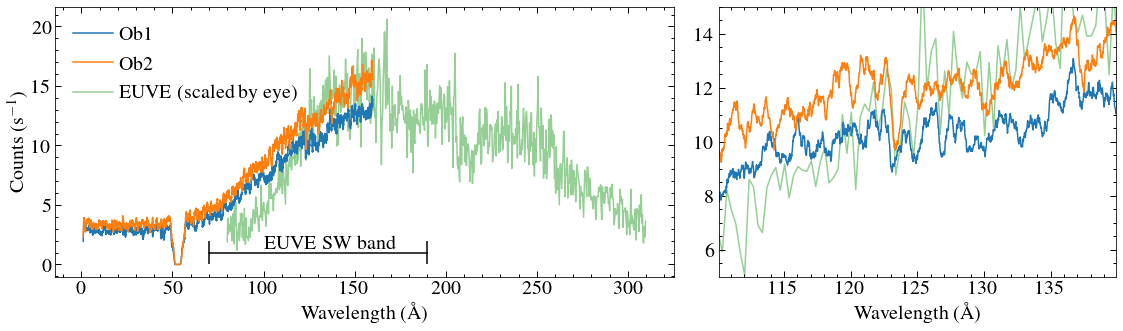

In [13]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 5, figure=fig)
plt.subplot(gs[0,:3])
for i, s in enumerate(sp):
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    mask = w < 160 
    plt.plot(w[mask], c1[mask], label = 'Ob{}'.format(i+1))
    #plt.plot(w, ce1)
#fv1 = convolve(fv,Box1DKernel(3))
plt.plot(wv, fv*3e13, zorder=-1, alpha=0.5, label='EUVE (scaled by eye)')
#plt.xscale('log')
#plt.xlim(10, 400)
plt.legend(loc=2)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Counts (s$^{-1}$)')
plt.errorbar([70,190],[1,1],  yerr=1,c='k')
plt.annotate('EUVE SW band', (100,1.3))


plt.subplot(gs[0,-2:])
for i, s in enumerate(sp):
    data = fits.getdata(s,1)
    w, c, ce = data['BIN_LO'], data['COUNTS'], data['STAT_ERR']
    c1 = convolve(c,Box1DKernel(smooth))
    ce1 = convolve(ce,Box1DKernel(smooth))/smooth**0.5
    mask = w < 160 
    plt.plot(w[mask], c1[mask], label = 'Ob{}'.format(i+1))
    #plt.plot(w, ce1)

plt.plot(wv, fv*3e13, zorder=-1, alpha=0.5, label='EUVE (scaled by eye)')
plt.xlim(110.1, 139.9)
plt.ylim(5, 15)
#plt.xscale('log')
#plt.xlim(10, 400)
#plt.legend()
plt.xlabel('Wavelength (\AA)')
#plt.ylabel('Counts (s$^{-1}$)')

plt.tight_layout()
plt.savefig('plots/gd394_chandra_1stlook.pdf')


In [14]:
#hdul[1].header

Quick scaling of the EUVE spectrum to see if observations of WD J1855+4207 might be possible with ESCAPE.

4.758987721261939e-13


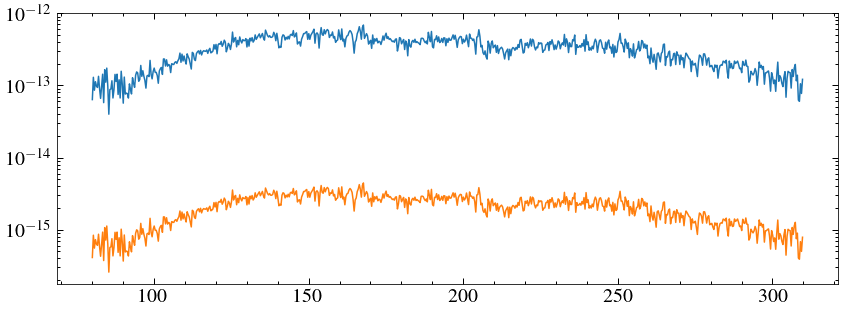

In [15]:
p394 = 19.849394614630985
p1885 = 1.5971289451975246
ratio = (p394/p1885)**2
plt.plot(wv, fv)
plt.plot(wv, fv/ratio)
plt.yscale('log')
print(np.trapz(fv/ratio, wv))

In [16]:
"""hdul = fits.open('/media/david/5tb_storage1/gd394_chandra/working/ob1/hrc_region_order1.fits')
hdul.info()
hdul.close()"""

"hdul = fits.open('/media/david/5tb_storage1/gd394_chandra/working/ob1/hrc_region_order1.fits')\nhdul.info()\nhdul.close()"

See if lightcurve extracted properly

In [17]:
path = '/media/david/5tb_storage1/gd394_chandra/working/'
tbin = 1000
obs = glob.glob(path+'ob*/')
obs

['/media/david/5tb_storage1/gd394_chandra/working/ob1/',
 '/media/david/5tb_storage1/gd394_chandra/working/ob2/']

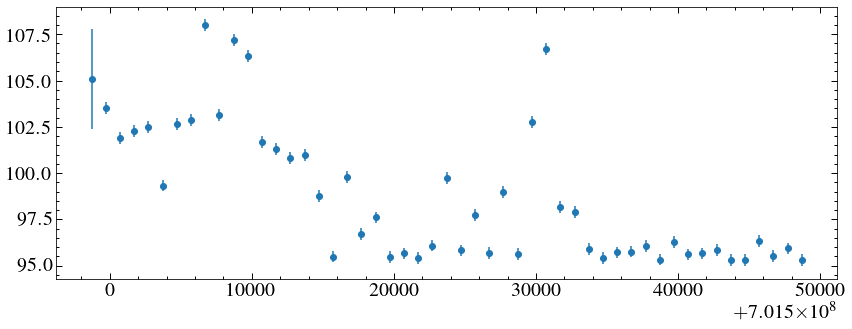

In [24]:
for ob in obs[0:1]:
    lcpath = glob.glob('{}hrc_lc*_{}.fits'.format(ob, tbin))[0]
    data = fits.getdata(lcpath, 1)
    t, c, e = data['TIME'][:-1], data['COUNT_RATE'][:-1], data['COUNT_RATE_ERR'][:-1]
    plt.errorbar(t, c, yerr=e, marker='o', ls='none')
    

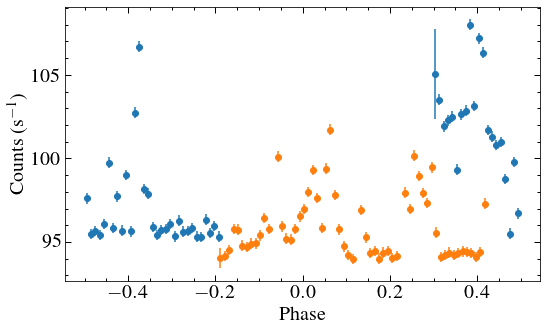

In [19]:
plt.figure(figsize=(8,5))
for ob in obs:
    lcpath = glob.glob('{}hrc_lc*_{}.fits'.format(ob, tbin))[0]
    data = fits.getdata(lcpath, 1)
    t, c, e = data['TIME']/86400, data['COUNT_RATE'], data['COUNT_RATE_ERR']
    #plt.errorbar(t-t[0], c, yerr=e, marker='o', ls='none')
    lc = lk.LightCurve(time=t, flux=c, flux_err=e ).remove_outliers(sigma=4)
    lc_fold = lc.fold(1.1468, t0 =2458737.560)
    plt.errorbar(lc_fold.time, lc_fold.flux, yerr=lc_fold.flux_err, marker='o', ls='none')
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$) ')
plt.tight_layout()
    

In [20]:
data.names

['TIME_BIN',
 'TIME_MIN',
 'TIME',
 'TIME_MAX',
 'COUNTS',
 'STAT_ERR',
 'AREA',
 'EXPOSURE',
 'COUNT_RATE',
 'COUNT_RATE_ERR']

<ErrorbarContainer object of 3 artists>

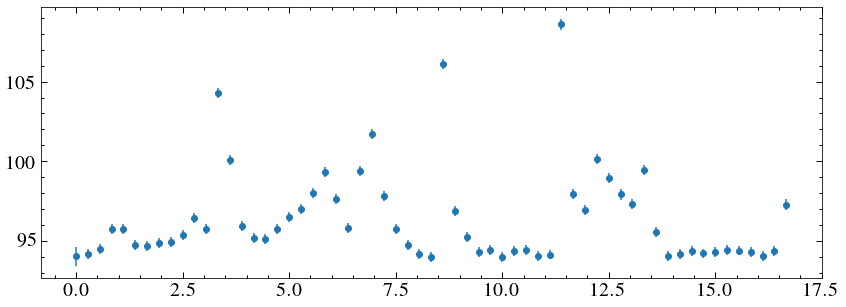

In [21]:
#plt.plot(data['TIME'], data['COUNTS'])
t, c, e = data['TIME'][:-1], data['COUNT_RATE'][:-1], data['COUNT_RATE_ERR'][:-1]
t = t - min(t)
t/= 3600
plt.errorbar(t, c, yerr=e, marker='o', ls='none')

#plt.errorbar(data['TIME'][:-1], data['COUNT_RATE'][:-1], yerr=data['COUNT_RATE_ERR'][:-1], marker='o', ls='none')
#plt.ylim(80000, 1.1*max(data['COUNTS']))

In [22]:
hdul.close()

In [43]:
hdul = fits.open('/media/david/5tb_storage1/gd394_chandra/working/ob1/ob1_test2_100lc.fits')
hdul.info()

Filename: /media/david/5tb_storage1/gd394_chandra/working/ob1/ob1_test2_100lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  LIGHTCURVE    1 BinTableHDU    301   520R x 10C   [1J, 1D, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1D]   
  2  GTI           1 BinTableHDU     26   1R x 2C   [1D, 1D]   


In [44]:
data = hdul[1].data

(90.0, 120.0)

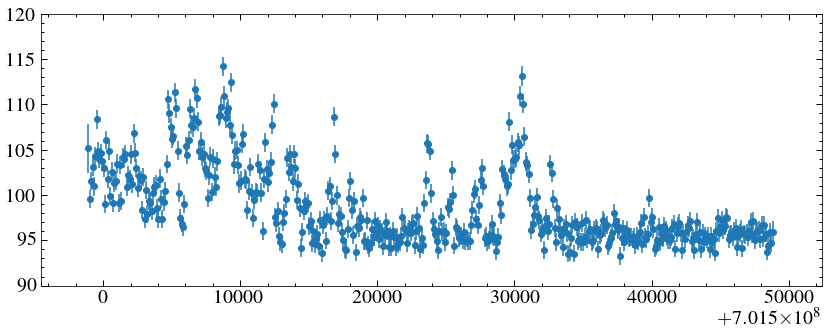

In [46]:
t, c, e = data['TIME'][:-1], data['COUNT_RATE'][:-1], data['COUNT_RATE_ERR'][:-1]
plt.errorbar(t, c, yerr=e, marker='o', ls='none')
plt.ylim(90,120)